# Load dataset

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 60)
traffic = pd.read_csv("traffic_fines_1.csv", sep=';', low_memory=False)
display(traffic.head(3))
traffic.shape

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,expense,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,0.0,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,11.0,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,11.0,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant


(460556, 21)

In [2]:
import EventLog as el

In [3]:
log = el.EventLog(traffic, 'Case ID', 'Complete Timestamp')

Found False


/Users/florianlang/ProgrammingProjects/python/predictive-monitoring-evolution/EventLog.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temp = pd.to_datetime(self.df[self.timestamp_column], infer_datetime_format=True,utc=True, errors='raise')


In [4]:
log.static_columns()

['article', 'vehicleClass', 'points', 'timesincemidnight', 'hour', 'label']

In [5]:
log.df.nunique()

article                   50
vehicleClass               4
amount                   204
points                     9
Case ID               129615
Activity                  10
Resource                 148
lastSent                   4
notificationType           3
dismissal                  8
expense                   84
Complete Timestamp      4903
timesincemidnight          1
month                     12
weekday                    7
hour                       1
timesincelastevent      1086
timesincecasestart      1360
event_nr                  20
open_cases             17274
label                      2
dtype: int64

# Preprocess and encode

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = el.LogEncoder(transformers = [('static_drop', 'drop', []),
                                     ('static_keep', 'keep', ['amount', 'points']),
                                     ('static_onehot', el.WrapperEncoder(log.id_column,OneHotEncoder(sparse_output=False)), ['article', 'vehicleClass']),
                                     ('dynamic_drop', 'drop', []),
                                     ('dynamic_keep', 'keep', ['expense', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases']),
                                     ('dynamic_freq', el.FrequencyEncoder(log.id_column), ['Activity', 'Resource', 'lastSent','notificationType', 'dismissal']),
                                     ('timestamp', el.TimestampFeatures(log.id_column, ['event_order', 'time_from_start', 'remaining_time', 'elapsed_time_from_event']), [log.timestamp_column])])


encoder.check_unused(log)

['Case ID', 'label']

In [7]:
X = encoder.fit_transform(log)

Fitting static_drop
Fitting static_keep
Fitting static_onehot
Fitting dynamic_drop
Fitting dynamic_keep
Fitting dynamic_freq
Fitting timestamp
Transforming static_drop
Transforming static_keep
Transforming static_onehot
Transforming dynamic_drop
Transforming dynamic_keep
Transforming dynamic_freq
Transforming timestamp


In [8]:
X.shape

(460556, 242)

In [9]:
(X.isnull().sum() > 0).sum()

0

# Descriptive analysis
We show some information concerning the distribution of the label (equally distributed), the categorical values and the events in each year (the number of events decreases with time and 2013 seems incomplete)

In [10]:
y = log.df['label']
y.value_counts()

label
deviant    239478
regular    221078
Name: count, dtype: int64

In [11]:
catcols = list(set(X.columns.values) - set(['amount', 'event_nr', 'expense', 'hour', 'month', 'open_cases', 'timesincecasestart', 'timesincelastevent', 'timesincemidnight', 'weekday']))

In [12]:
X.loc[:,catcols].max()

article_170.0                     1.0
Resource_27.0                       9
event_order_Complete Timestamp     19
Resource_36.0                       9
Resource_35.0                      10
                                 ... 
Resource_3.0                        4
Resource_817.0                      6
article_193.0                     1.0
article_189.0                     1.0
article_145.0                     1.0
Length: 232, dtype: object

In [13]:
log.df[log.timestamp_column].dt.year.value_counts()

Complete Timestamp
2000    49467
2006    46157
2005    43633
2001    41835
2009    37676
2002    36165
2007    35385
2008    34177
2011    31678
2004    30191
2003    29034
2010    27840
2012    14715
2013     2603
Name: count, dtype: int64

# Experiments

## RQ1: Does the dataset changes over time?
To answer this question, we split the dataset into a set of intervals (e.g. each 9 months) and test whether the distribution of values of categorical attributes between the different intervals is statistically significant using chi2

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_heatmap(data, vmax=None):
    s = len(data.columns)+1
    yticklabels=['[I'+str(i)+"] "+data.columns[i-1].left.strftime('%m-%Y') + " to " + data.columns[i-1].right.strftime('%m-%Y') for i in range(1,s)]
    xticklabels=['[I'+str(i)+']' for i in range(1,s)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, yticklabels = yticklabels, xticklabels=xticklabels,vmax=vmax)
    ax.set_xlabel("")
    ax.set_ylabel("")    
    
    return ax

In [15]:
from splitters import TimeCaseSplit
from splitters import DriftStrategy, CombineStrategy, CummulativeStrategy, SamplingStrategy, NonCummulativeStrategy
from contingency import compute_all_chi2

current_strategy = CummulativeStrategy()

tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100)
splits = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy=current_strategy)

allchi2 = compute_all_chi2(X.loc[:,catcols], splits)

DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005-04-03 01:00:00+00:00',
               '2006-01-03 01:00:00+00:00', '2006-10-03 01:00:00+00:00',
               '2007-07-03 01:00:00+00:00', '2008-04-03 01:00:00+00:00',
               '2009-01-03 01:00:00+00:00', '2009-10-03 01:00:00+00:00',
               '2010-07-03 01:00:00+00:00', '2011-04-03 01:00:00+00:00',
               '2012-01-03 01:00:00+00:00', '2012-10-03 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='<DateOffset: months=9>')
Split no.: 1 
Split no.: 2 
Split no.: 3 
Split no.: 4 
Split no.: 5 
Split no.: 6 
Split no.: 7 
Split no.: 8 
Split no.: 9 
Split no.: 10 
Split no.: 11 
Split no.: 12 
Split no.: 13 
Split no.: 14 
Split no.: 15 
Split no.: 16 
Split no.: 17 
Split no.: 18 
Split n

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_37074/3220553523.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))


<Axes: >

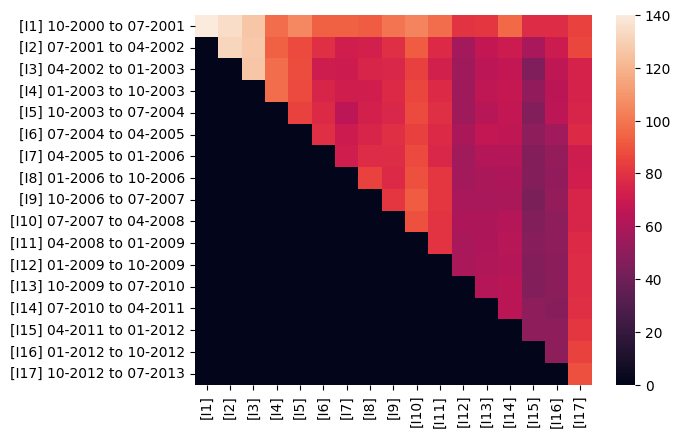

In [16]:
draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))

The conclusion is that there is a difference between the first years of the dataset (until 2003) and the last years (before 2003). Furthermore, as expected, there are more similarities in the diagonal, which represent consecutive intervals.

We can look at one of the attributes in detail to see how can these results be interpreted. For instance, let's have a look to Resource 825

In [21]:
tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100)
resource825_sum, resource825_detail = compute_all_chi2(X.loc[:,['Resource_825.0']], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy = current_strategy),verbose=True)

DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005-04-03 01:00:00+00:00',
               '2006-01-03 01:00:00+00:00', '2006-10-03 01:00:00+00:00',
               '2007-07-03 01:00:00+00:00', '2008-04-03 01:00:00+00:00',
               '2009-01-03 01:00:00+00:00', '2009-10-03 01:00:00+00:00',
               '2010-07-03 01:00:00+00:00', '2011-04-03 01:00:00+00:00',
               '2012-01-03 01:00:00+00:00', '2012-10-03 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='<DateOffset: months=9>')
Split no.: 1 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",29333,136,78,132,189,36,18
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0


4.551727549064172e-51
Split no.: 2 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"(2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32297,154,246,195,186,35,19,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0


8.469272274476101e-62
Split no.: 3 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0,0


5.976782274961494e-40
Split no.: 4 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0


1.975920815365298e-29
Split no.: 5 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 6 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 7 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 8 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 9 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 10 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 11 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 12 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 13 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 14 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 15 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 16 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 17 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 18 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"(2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32297,154,246,195,186,35,19,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18,0


6.201451186208299e-19
Split no.: 19 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18,0,0,0


0.0002150109203802532
Split no.: 20 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18,0,0


1.6049616898659653e-59
Split no.: 21 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


7.4030914766164e-63
Split no.: 22 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


7.688975061085525e-119
Split no.: 23 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


1.732609330897764e-117
Split no.: 24 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


5.273521354209857e-118
Split no.: 25 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


1.0441098334802415e-105
Split no.: 26 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


9.252593819252608e-99
Split no.: 27 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


8.865213553553895e-99
Split no.: 28 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


1.1496643251406784e-107
Split no.: 29 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


1.9397395397520774e-70
Split no.: 30 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


8.11938054159765e-68
Split no.: 31 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


1.1943697390294527e-103
Split no.: 32 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


2.8409462372009995e-43
Split no.: 33 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",58175,287,287,197,191,33,18


2.7946912916483044e-16
Split no.: 34 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36,0,0,0


0.00903927479498754
Split no.: 35 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36,0,0


9.389223297445341e-74
Split no.: 36 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


1.6847347470462842e-75
Split no.: 37 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


3.327491647796973e-142
Split no.: 38 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


1.3680558254484652e-140
Split no.: 39 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


3.30958812997543e-141
Split no.: 40 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


1.5547665644404293e-126
Split no.: 41 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


3.0373860668012757e-118
Split no.: 42 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


2.886243627690048e-118
Split no.: 43 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


7.162244619059994e-129
Split no.: 44 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


1.9562913790871026e-84
Split no.: 45 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


2.644169651929658e-81
Split no.: 46 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


4.4457962955420706e-124
Split no.: 47 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


5.5607986155080736e-52
Split no.: 48 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",93241,536,536,394,370,61,36


1.1379717058987645e-19
Split no.: 49 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,0,1,1
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


3.7588436907328804e-72
Split no.: 50 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,0,2,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


3.8622356551746136e-73
Split no.: 51 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


1.0462317776774333e-139
Split no.: 52 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


4.295926793724757e-138
Split no.: 53 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


1.0398014658279075e-138
Split no.: 54 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


4.783652838437326e-124
Split no.: 55 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


9.153107670879624e-116
Split no.: 56 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


8.69821045717625e-116
Split no.: 57 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


2.213845789585069e-126
Split no.: 58 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


4.93492282919871e-82
Split no.: 59 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


6.495604901659956e-79
Split no.: 60 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


1.3604717530320286e-121
Split no.: 61 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


9.278420771781422e-50
Split no.: 62 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",118572,694,694,505,446,76,47,1,1,1


6.3412135490334015e-18
Split no.: 63 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,0,2,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


9.716608319456755e-67
Split no.: 64 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


6.489805572442628e-128
Split no.: 65 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


1.9681501641195287e-126
Split no.: 66 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


5.348216070495056e-127
Split no.: 67 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


1.56235394778964e-113
Split no.: 68 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


6.283406020005676e-106
Split no.: 69 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


5.996094765323069e-106
Split no.: 70 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


1.121918557883246e-115
Split no.: 71 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


5.748521084689098e-75
Split no.: 72 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


4.183590768882083e-72
Split no.: 73 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


2.799559735688078e-111
Split no.: 74 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


2.2728439477261228e-45
Split no.: 75 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",137752,728,728,539,479,90,59,2,2,2


3.064932043283593e-16
Split no.: 76 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


5.337319263752772e-110
Split no.: 77 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


1.0195343194350144e-108
Split no.: 78 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


3.305328053111419e-109
Split no.: 79 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


1.44154443036731e-97
Split no.: 80 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


5.375628917273199e-91
Split no.: 81 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


5.162559869818861e-91
Split no.: 82 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


2.022802230529131e-99
Split no.: 83 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


2.9558171170736292e-64
Split no.: 84 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


8.72623970456833e-62
Split no.: 85 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


1.2771189841492673e-95
Split no.: 86 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


9.86601401675678e-39
Split no.: 87 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",160015,730,730,541,481,92,61,2,2,2


1.0387222475199836e-13
Split no.: 88 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


9.283011784903598e-94
Split no.: 89 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


3.495058989160566e-94
Split no.: 90 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


4.326661604940046e-84
Split no.: 91 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


2.152395284698377e-78
Split no.: 92 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


2.0782491060163153e-78
Split no.: 93 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


1.0708735356001377e-85
Split no.: 94 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


3.155219018235576e-55
Split no.: 95 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


4.340238652418422e-53
Split no.: 96 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


2.11071715196754e-82
Split no.: 97 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


3.7649995473276125e-33
Split no.: 98 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",184349,730,730,541,481,92,61,2,2,2


1.3377888599691561e-11
Split no.: 99 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


2.1045409993219607e-80
Split no.: 100 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


9.828250760315326e-72
Split no.: 101 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


7.662877688788271e-67
Split no.: 102 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


7.435667110304721e-67
Split no.: 103 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


4.100362459917602e-73
Split no.: 104 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


5.797662995268351e-47
Split no.: 105 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


3.9517123393340365e-45
Split no.: 106 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


2.7691459974868073e-70
Split no.: 107 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


4.696745704299161e-28
Split no.: 108 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",214251,730,730,541,481,92,61,2,2,2


1.0820594071041746e-09
Split no.: 109 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


2.421098410177378e-62
Split no.: 110 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


4.592244409605255e-58
Split no.: 111 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


4.472957456127552e-58
Split no.: 112 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


1.5042859981653524e-63
Split no.: 113 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


1.0818427997254624e-40
Split no.: 114 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


4.317279147648578e-39
Split no.: 115 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


4.487770798586729e-61
Split no.: 116 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


3.372573331600399e-24
Split no.: 117 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",244436,730,730,541,481,92,61,2,2,2


2.9010944916963702e-08
Split no.: 118 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


1.9155880225926265e-50
Split no.: 119 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


1.8719854036718217e-50
Split no.: 120 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


3.0430397182752296e-55
Split no.: 121 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


2.954535380825913e-35
Split no.: 122 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


7.39646756780029e-34
Split no.: 123 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


4.454503560315412e-53
Split no.: 124 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


7.266240042998815e-21
Split no.: 125 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",278592,730,730,541,481,92,61,2,2,2


4.822308031766202e-07
Split no.: 126 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


1.6838761787251553e-45
Split no.: 127 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


7.649662162893949e-50
Split no.: 128 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


9.983260234788978e-32
Split no.: 129 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


1.8439875036347264e-30
Split no.: 130 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


7.037903764348645e-48
Split no.: 131 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


1.0448322621793569e-18
Split no.: 132 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",306501,730,730,541,481,92,61,2,2,2


2.915283115490292e-06
Split no.: 133 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


1.644500938010631e-45
Split no.: 134 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


6.702848980496617e-29
Split no.: 135 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


9.69492103012033e-28
Split no.: 136 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


1.0413252055438571e-43
Split no.: 137 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


5.54000183171645e-17
Split no.: 138 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",333348,730,730,541,481,92,61,2,2,2


1.2109200377599948e-05
Split no.: 139 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",362399,730,730,541,481,92,61,2,2,2


2.535708751631939e-26
Split no.: 140 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",362399,730,730,541,481,92,61,2,2,2


2.93199812910445e-25
Split no.: 141 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",362399,730,730,541,481,92,61,2,2,2


6.685695689292258e-40
Split no.: 142 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",362399,730,730,541,481,92,61,2,2,2


2.05198173137074e-15
Split no.: 143 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",362399,730,730,541,481,92,61,2,2,2


4.3660048003548794e-05
Split no.: 144 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",383978,730,730,541,481,92,61,2,2,2


1.1513591385657618e-23
Split no.: 145 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",383978,730,730,541,481,92,61,2,2,2


1.8841001162922433e-37
Split no.: 146 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",383978,730,730,541,481,92,61,2,2,2


2.080196207418741e-14
Split no.: 147 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",383978,730,730,541,481,92,61,2,2,2


9.862536356122123e-05
Split no.: 148 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",402106,730,730,541,481,92,61,2,2,2


1.339053193868153e-35
Split no.: 149 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",402106,730,730,541,481,92,61,2,2,2


1.1923055657347352e-13
Split no.: 150 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",402106,730,730,541,481,92,61,2,2,2


0.00018149125580304738
Split no.: 151 
[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",432870,730,730,541,481,92,61,2,2,2


1.6285431500488015e-12
Split no.: 152 
[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",432870,730,730,541,481,92,61,2,2,2


0.0004487402934085106
Split no.: 153 
[2000-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0,0,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",451114,730,730,541,481,92,61,2,2,2


0.0007191526918683556


/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_37074/3502969517.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))


<Axes: xlabel='test_interval', ylabel='train_interval'>

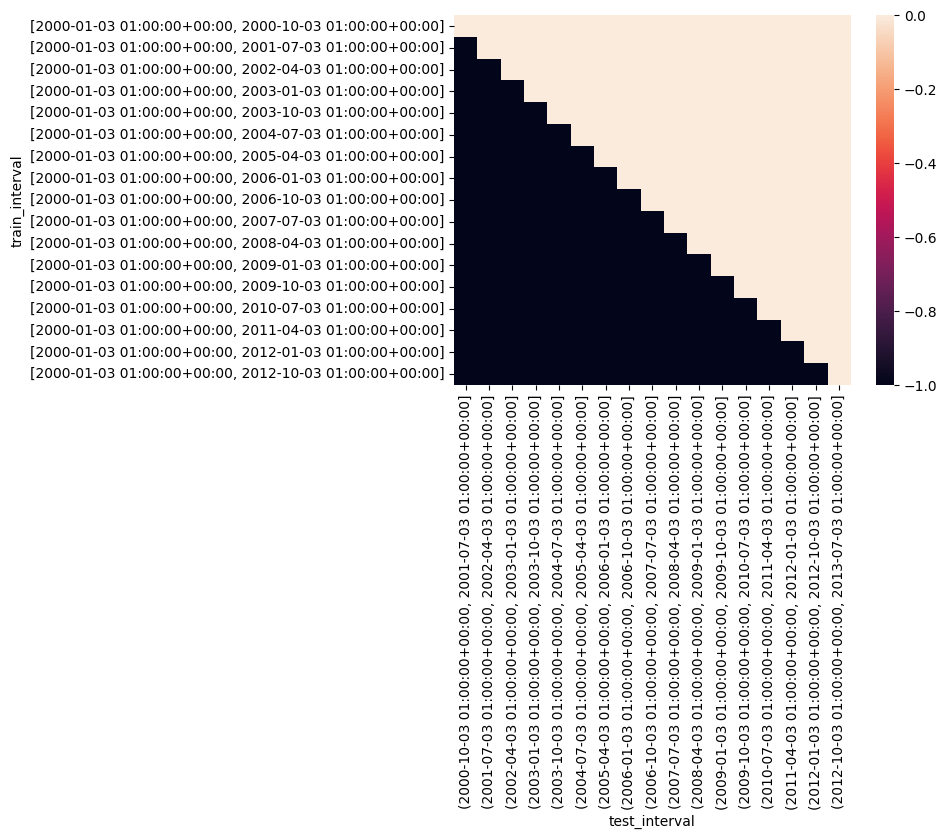

In [22]:
sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))

The conclusion is that there is no difference in the dataset since 2004. If we look into the details, we see that this resource stop appearing in the process in 2004. Actually, this coincides with the gap that we detected in the process in that year.

# RQ2: Does time have an influence on the quality of the models?
To answer this question, we are going to analyse the evolution of model performance using the first two strategies (new models each time and updating a model that includes all information):

In [23]:
from experiments import run_experiment_classifier, run_experiment_classifier_voting, compare_diag, compute_weights, shape_summary, run_experiment_classifier_old
from splitters import TimeCaseSplit, NumberCaseSplit

def launch_experiment_rq2(months_size, months_freq, months_test):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsV = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsF = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier_old(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier_old(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V = run_experiment_classifier_voting(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V

def launch_experiment_rolling(size, freq, window, steps, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier_old(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),window, steps, summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier_old(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), window, steps,summary_class='regular')
    print('Starting X_V')
    
    return summary_X, summary_X_F, summary_X_V


def launch_experiment_number(size, freq, test, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20,threshold=500,  sliding=True)
    tcsV = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False)
    tcsS = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False, sampling=True)
    print('Starting X_S')
    summary_X_S = run_experiment_classifier(X, y, tcsS.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X')
    summary_X = run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F =run_experiment_classifier(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V= run_experiment_classifier_voting(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    
    return summary_X, summary_X_F, summary_X_V, summary_X_S
        

ImportError: cannot import name 'run_experiment_classifier' from 'experiments' (/Users/florianlang/ProgrammingProjects/python/predictive-monitoring-evolution/experiments.py)

In [ ]:
summary_999 = launch_experiment_rq2(9,9,9)

Starting X
Starting X_F
Starting X_V


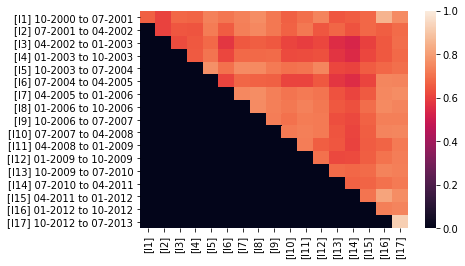

In [ ]:
from experiments import shape_summary
draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

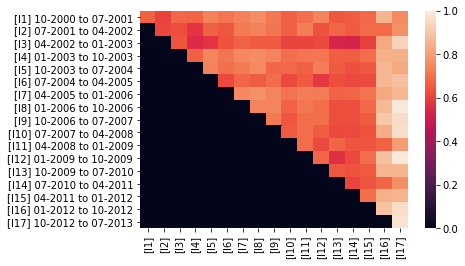

In [ ]:
draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

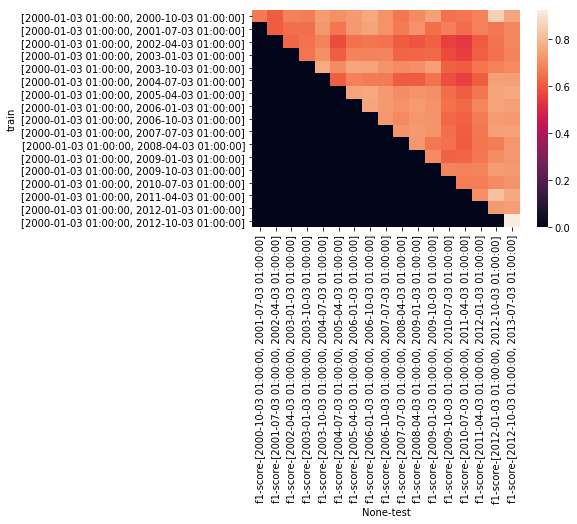

In [ ]:
sns.heatmap(shape_summary(summary_9_F_r).fillna(0))

In [ ]:
summary_n, summary_n_F, summary_n_V, summary_n_S = launch_experiment_number(8641,4320,4320)

Starting X_S
Sampling from: 8641 in 1
Sampling from: 12961 in 2
Sampling from: 17281 in 3
Sampling from: 21601 in 4
Sampling from: 25921 in 5
Sampling from: 30241 in 6
Sampling from: 34561 in 7
Sampling from: 38881 in 8
Sampling from: 43201 in 9
Sampling from: 47521 in 10
Sampling from: 51841 in 11
Sampling from: 56161 in 12
Sampling from: 60481 in 13
Sampling from: 64801 in 14
Sampling from: 69121 in 15
Sampling from: 73441 in 16
Sampling from: 77761 in 17
Sampling from: 82081 in 18
Sampling from: 86401 in 19
Sampling from: 90721 in 20
Sampling from: 95041 in 21
Sampling from: 99361 in 22
Sampling from: 103681 in 23
Sampling from: 108001 in 24
Sampling from: 112321 in 25
Sampling from: 116641 in 26
Sampling from: 120961 in 27
Sampling from: 125281 in 28
Sampling from: 129601 in 29
Sampling from: 129614 in 30
Starting X
Starting X_F
Starting X_V


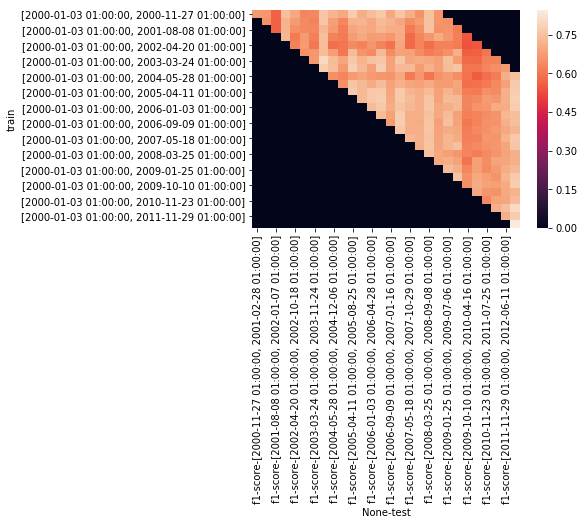

In [ ]:
sns.heatmap(shape_summary(summary_n_F).fillna(0))

# RQ3: How does the different update strategies compare against each other?

Finally, we compute execute the experiment for all types of strategies. The final value is the mean of the F-Scores in the diagonal of the matrix obtained.

In [ ]:
summary_n_all = [summary_n, summary_n_F, summary_n_V, summary_n_S]

In [ ]:
def extract_values(summary, step = 0):
    mask = summary[0].sort_values(['train','test']).groupby('train').cumcount() <= step
    return pd.concat([summary[i][mask]['f1-score'] for i in range(len(summary))],axis=1)

In [ ]:
summary_n_fscore = extract_values(summary_n_all)
summary_n_fscore.columns = ['X','F','V','S']


In [ ]:
summary_n_fscore.mean()

X    0.694372
F    0.703657
V    0.714230
S    0.705357
dtype: float64

Here, we use the T-test related to check whether there is a significant difference between each column. The result is that only the difference between 'V' and 'X is statistically significant.

In [ ]:
from scipy import stats
[(i,j,stats.ttest_rel(summary_n_fscore[i], summary_n_fscore[j])) for ii,i in enumerate(summary_n_fscore.columns) for jj,j in enumerate(summary_n_fscore.columns) if i < j]

[('F',
  'X',
  Ttest_relResult(statistic=1.2527671941138439, pvalue=0.22103241726995335)),
 ('F',
  'V',
  Ttest_relResult(statistic=-1.3650320688729325, pvalue=0.18351044883548195)),
 ('F',
  'S',
  Ttest_relResult(statistic=-0.46362856787053, pvalue=0.6466298815649716)),
 ('V',
  'X',
  Ttest_relResult(statistic=3.1507531132969744, pvalue=0.003957876483001759)),
 ('S',
  'X',
  Ttest_relResult(statistic=1.6928052455530407, pvalue=0.10200215288924347)),
 ('S',
  'V',
  Ttest_relResult(statistic=-1.1216114246414404, pvalue=0.27190415125728346))]